In [1]:
import numpy as np
from numba import njit, prange
import csv
import os
import pandas as pd
from glob import glob
import time
import matplotlib.pyplot as plt
from src import functions as fcts
import scipy.stats as sc
import shutil
from sklearn.cluster import DBSCAN
from mpl_toolkits.mplot3d import Axes3D
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
from sklearn.cluster import KMeans
from scipy.spatial import KDTree
import math
import sys
import PIL
import random
import ripleyk
from skimage import measure
import seaborn as sns
import pandas as pd

print(sys.executable)

/Users/isabellegarnreiter/opt/anaconda3/envs/vesicleSTORM/bin/python


In [ ]:
#upload csv file

storm_data = pd.read_pickle('/users/isabellegarnreiter/documents/vesicleSTORM/data/storm_data.pkl')



In [3]:
#initialise paramaters for the detection/selection of synapses

params = {}
params['true_roi_size'] = (49660,49660,1100)
params['sf']  = (68, 68, 180)
params['kernel_size'] = (50,50,2)
params['sigma'] = 10
params['max_threshold_ves'] = 6
params['min_peak_dist'] = 20
params['min_cluster_area'] = 10 
params['max_cluster_area'] = 50000

In [4]:
from sklearn.cluster import KMeans
random.seed(0)
simulation, sim_params = fcts.simulation_batch(5, [17,17,50], [1000,1000,20])

peak_coords, sim_clusters, sim_vesicles = fcts.get_clustered_points(simulation[0], params)

# Create a 3D scatter plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

peak_coords_plot = peak_coords*params['sf']

ax.scatter(simulation[0][:, 0], simulation[0][:, 1], simulation[0][:, 2], marker='o', alpha=0.5)
ax.scatter(peak_coords_plot[:, 0], peak_coords_plot[:, 1], peak_coords_plot[:, 2], c='black')

# Set axis labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Display the plot
plt.show()
print(np.max(sim_clusters))


AttributeError: module 'src.functions' has no attribute 'get_clustered_points'

In [36]:
def normalize_array(arr):
    min_val = np.min(arr)
    max_val = np.max(arr)
    return (arr - min_val) / (max_val - min_val)

# apply the normalization function to the column of arrays
storm_data['nn_680_normalized'] = storm_data['nearest_neighbor_680'].apply(normalize_array)


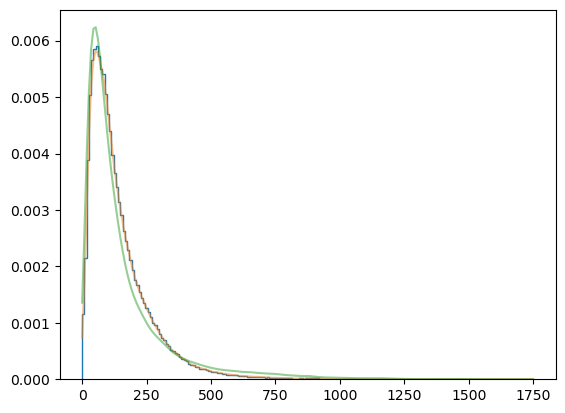

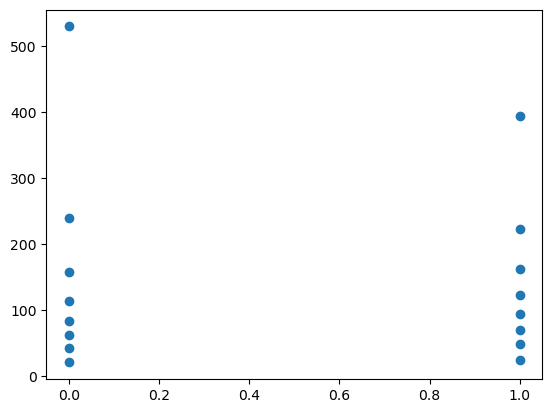

In [108]:
# concatenate the normalized arrays into a single numpy array
dep_array = np.concatenate(storm_data[storm_data['647nm']=='DEP647']['nearest_neighbor_680'].to_numpy())
spon_array = np.concatenate(storm_data[storm_data['647nm']=='SPON647']['nearest_neighbor_680'].to_numpy())

n, x, _ = plt.hist(dep_array, bins=200, 
                   histtype=u'step', density=True)  

density_dep = sc.gaussian_kde(dep_array)
density_spon = sc.gaussian_kde(spon_array)


plt.plot(x, density_dep(x), alpha=0.5)
plt.plot(x, density_spon(x), alpha=0.5)

plt.show()


dep_array = np.sort(dep_array)
spon_array = np.sort(spon_array)

dep_array_sorted = dep_array[:-1].reshape((8, dep_array[:-1].shape[0]//8))
dep_array_sorted_mean = np.mean(dep_array_sorted, axis=1)
spon_array_sorted = spon_array[:-1].reshape((8, spon_array[:-1].shape[0]//8))
spon_array_sorted_mean = np.mean(spon_array_sorted, axis=1)

plt.scatter(x=[np.zeros(8), np.ones(8)], y = [spon_array_sorted_mean, dep_array_sorted_mean])
plt.show()

In [135]:
dep_array = storm_data[storm_data['647nm']=='DEP647']['nearest_neighbor_680'].to_numpy()
spon_array = storm_data[storm_data['647nm']=='SPON647']['nearest_neighbor_680'].to_numpy()
    
quarter_len = storm_data['nearest_neighbor_680'].apply(lambda x: len(x) // 4)
quarter_len = quarter_len.to_numpy()
# separate the array into quarters and calculate the mean of each quarter
quarter_means = pd.DataFrame()
for i in range(4):
    quarter_arr = storm_data['nearest_neighbor_680'].apply(lambda x: x[i*quarter_len:(i+1)*quarter_len])
    quarter_mean = quarter_arr.apply(lambda x: np.mean(x))
    quarter_means[f'quarter_{i+1}_mean'] = quarter_mean

print(quarter_means)

TypeError: only integer scalar arrays can be converted to a scalar index

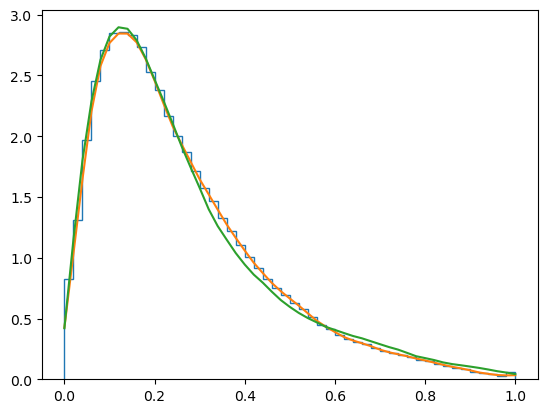

In [76]:
# concatenate the normalized arrays into a single numpy array
dep_array_norm = np.concatenate(storm_data[storm_data['647nm']=='DEP647']['nn_680_normalized'].to_numpy())
spon_array_norm = np.concatenate(storm_data[storm_data['647nm']=='SPON647']['nn_680_normalized'].to_numpy())

n, x, _ = plt.hist(dep_array, bins=50, 
                   histtype=u'step', density=True)  


density_dep = sc.gaussian_kde(dep_array_norm)
density_spon = sc.gaussian_kde(dep_array_norm)


plt.plot(x, density_dep(x))
plt.plot(x, density_spon(x))

plt.show()

In [18]:
#compute the n shortest distances from one vesicles to its n neighbors for each vesicle

n = 50

all_points = storm_data['points'].to_numpy()

NNDs = np.array([])
for points in all_points:
    tree = KDTree(points)
    nearest_dist, nearest_ind = tree.query(points, k=n+1) 
    NNDs = np.concatenate((NNDs, nearest_dist), axis=None)

NNDs = NNDs.reshape((int(NNDs.shape[0]/(n+1)), n+1))
NNDs.shape
NNDs_df  = pd.DataFrame(NNDs, columns = np.array(range(0,n+1)))


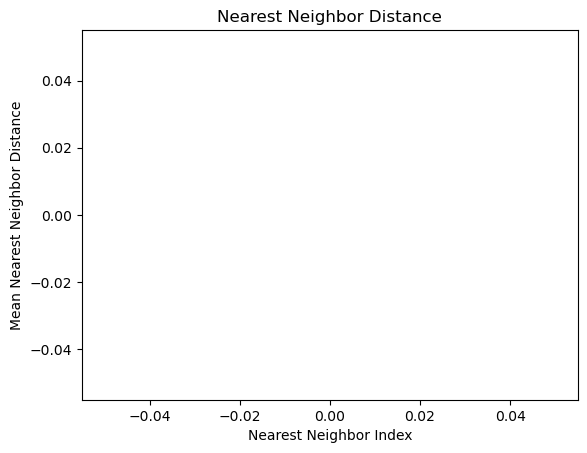

In [19]:

# Create a scatter plot
#plt.scatter(NNDs_df.columns.values, NNDs_df.mean(axis=0))
plt.plot(np.unique(NNDs_df.columns.values), np.poly1d(np.polyfit(NNDs_df.columns.values, NNDs_df.mean(axis=0), 1))(np.unique(NNDs_df.columns.values)))

# Set the  -axis label
plt.xlabel('Nearest Neighbor Index')

# Set the y-axis label
plt.ylabel('Mean Nearest Neighbor Distance')

# Set the plot title
plt.title('Nearest Neighbor Distance')

# Show the plot
plt.show()

In [1]:
n=32
avg_nnd = pd.DataFrame()
for condition in ['SPON647', 'DEP647']:
    nnd_array = np.array(storm_data[storm_data['647nm'] == condition]['15_NNs_647'].to_list(), dtype=object)
    nnd_array = np.concatenate((nnd_array), axis=None)
    nnd_array = nnd_array.reshape((int(nnd_array.shape[0]/(n+1)), n+1))
    
    avg_nnd[condition] = np.mean(nnd_array, axis=0)
    print(avg_nnd[condition].shape)
    
# Step 2: Plot average nearest neighbor distances for each condition
fig, ax = plt.subplots()
ax.plot(avg_nnd)
ax.set_xlabel('Rank')
ax.set_ylabel('Average nearest neighbor distance')
plt.show()

NameError: name 'pd' is not defined

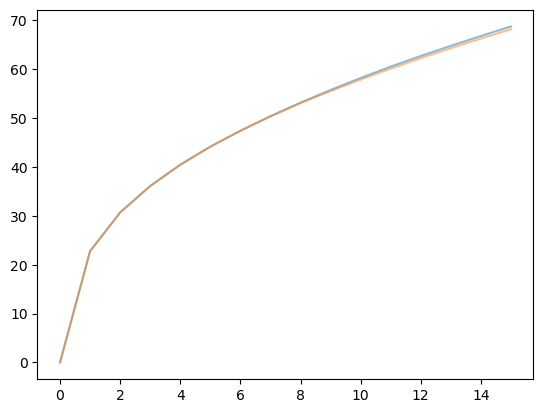

In [473]:
plt.plot(avg_nnd, alpha=0.5)

In [ ]:
def project_3d_to_2d(arr):
    # Get the maximum value of the array along the z-axis
    # Get the sum of the maximum values along the x and y axes
    projection = np.sum(arr, axis=2)
    
    return projection

for file_name in list(synapses.keys()):
    print(file_name)
    im = project_3d_to_2d(synapses[file_name])
    plt.imshow(im)
    plt.show()

210415 DEP647_VAMP2 8DIV_CellZone0
11
1689


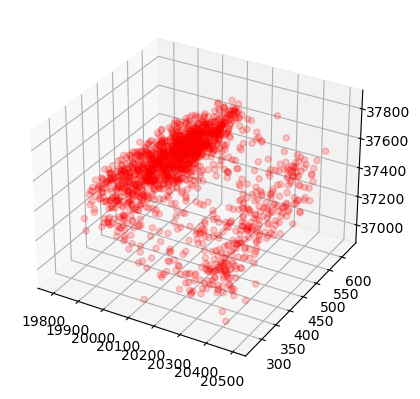

210415 DEP647_VAMP2 8DIV_CellZone0
12
2274


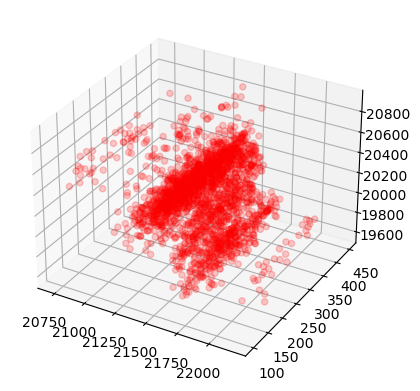

210415 DEP647_VAMP2 8DIV_CellZone0
6
1601


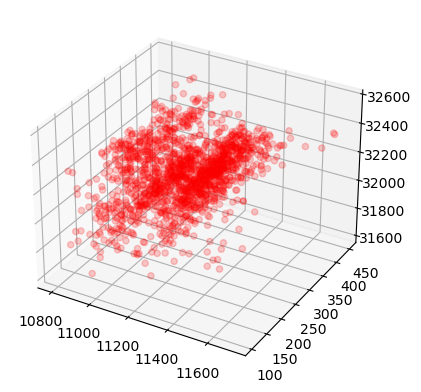

210415 DEP647_VAMP2 8DIV_CellZone0
16
2348


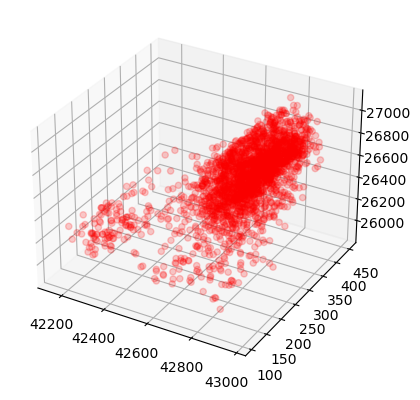

210415 DEP647_VAMP2 8DIV_CellZone0
3
2139


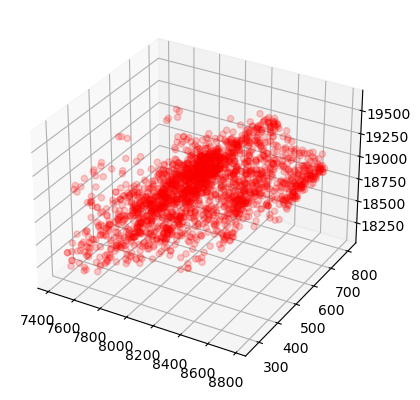

210415 DEP647_VAMP2 8DIV_CellZone0
15
2640


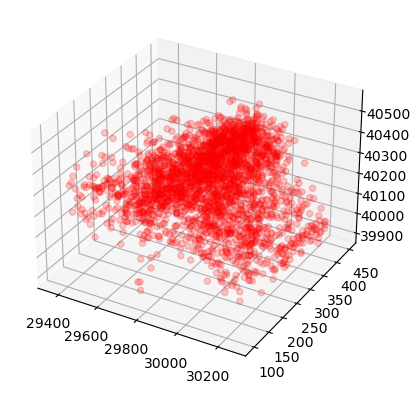

210415 DEP647_VAMP2 8DIV_CellZone1
8
2090


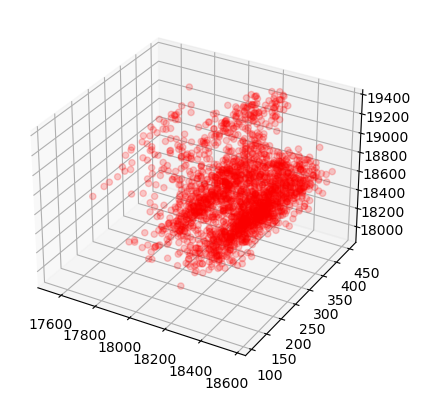

210415 DEP647_VAMP2 8DIV_CellZone1
3
2643


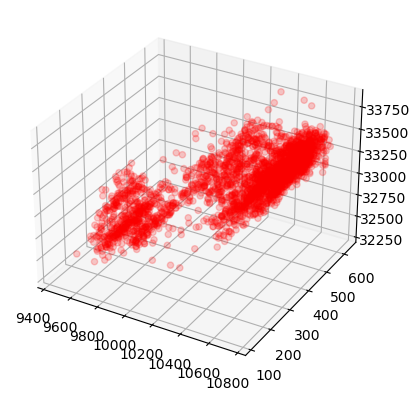

210415 DEP647_VAMP2 8DIV_CellZone1
1
2769


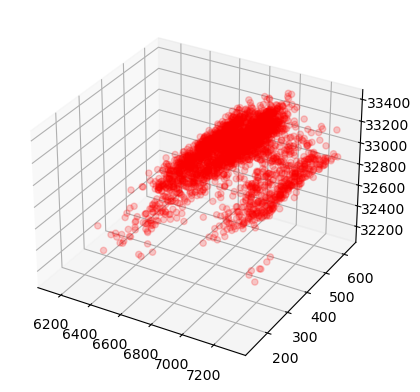

210415 DEP647_VAMP2 8DIV_CellZone1
13
4075


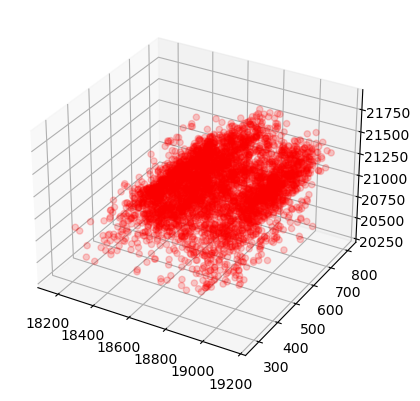

210415 DEP647_VAMP2 8DIV_CellZone1
4
2576


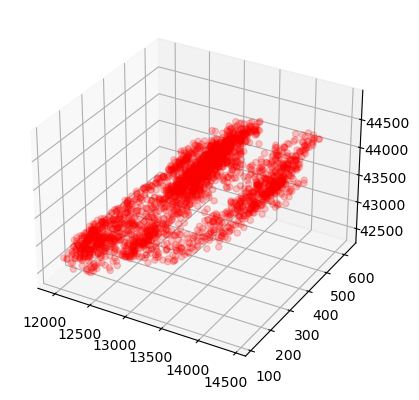

210415 DEP647_VAMP2 8DIV_CellZone1
20
908


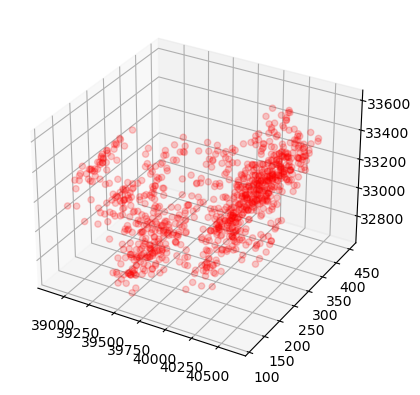

210415 DEP647_VAMP2 8DIV_CellZone1
2
1836


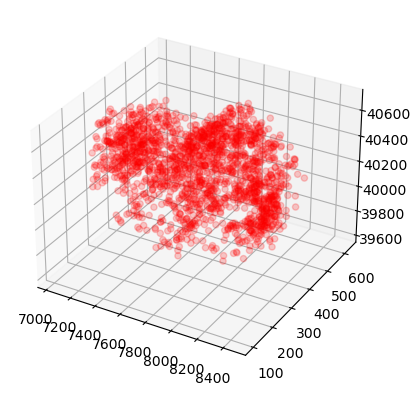

210415 DEP647_VAMP2 8DIV_CellZone1
7
2417


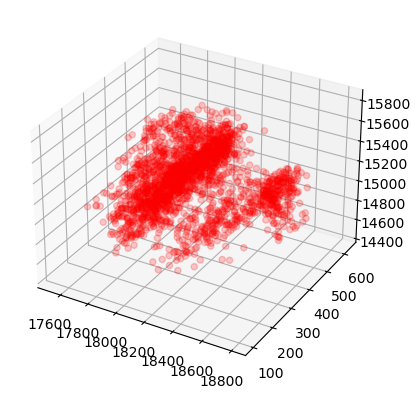

210415 DEP647_VAMP2 8DIV_CellZone2
4
812


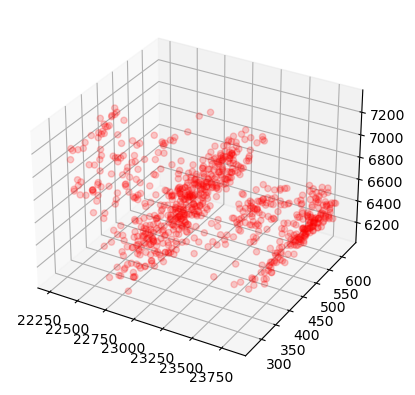

210415 DEP647_VAMP2 8DIV_CellZone2
10
806


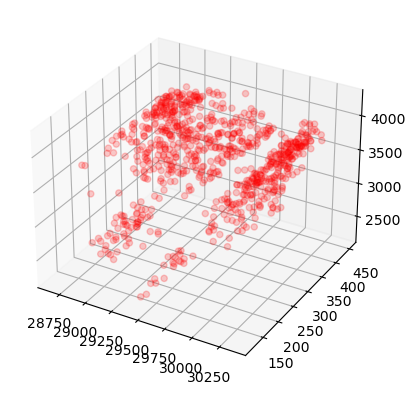

210415 DEP647_VAMP2 8DIV_CellZone2
9
993


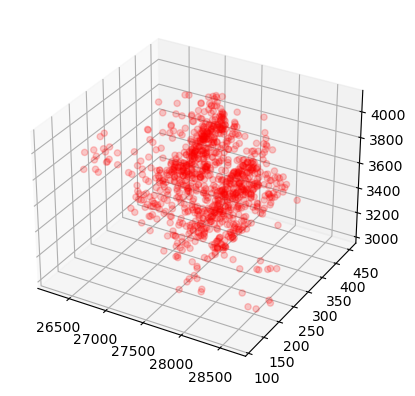

210415 DEP647_VAMP2 8DIV_CellZone2
11
765


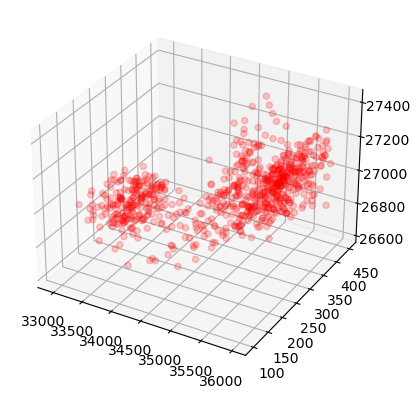

210415 DEP647_VAMP2 8DIV_CellZone2
2
943


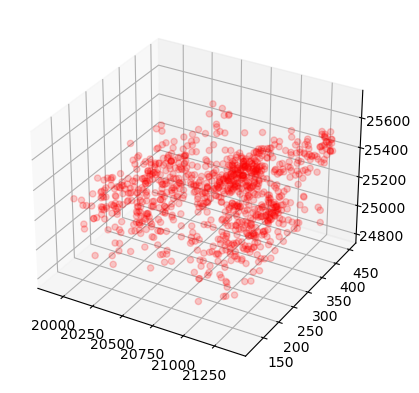

210415 DEP647_VAMP2 8DIV_CellZone2
7
827


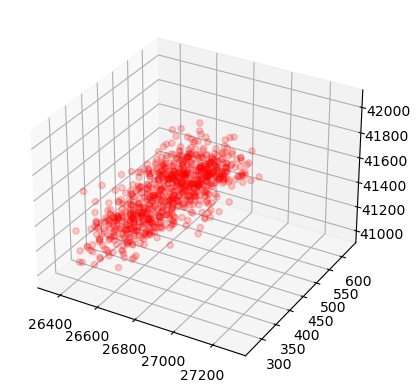

210415 DEP647_VAMP2 8DIV_CellZone3
4
173


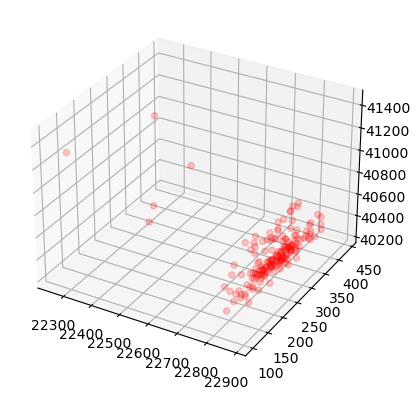

210415 DEP647_VAMP2 8DIV_CellZone3
11
108


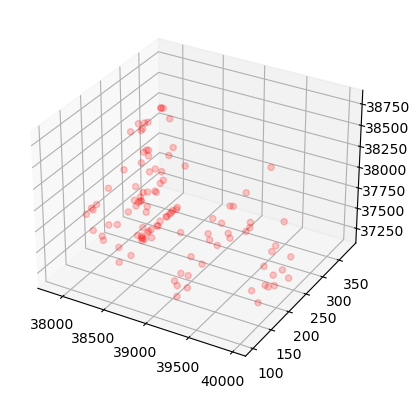

210415 DEP647_VAMP2 8DIV_CellZone3
6
138


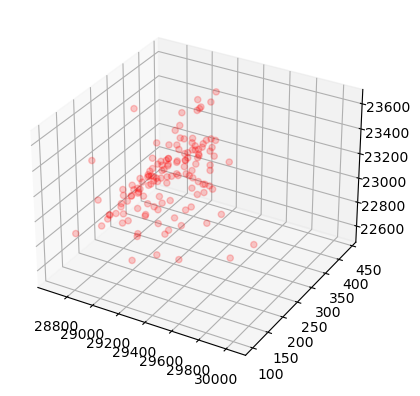

210415 DEP647_VAMP2 8DIV_CellZone3
5
149


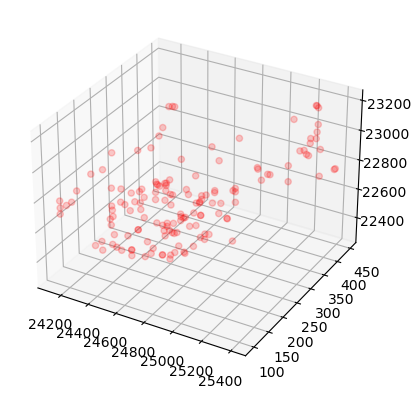

210415 DEP647_VAMP2 8DIV_CellZone3
9
89


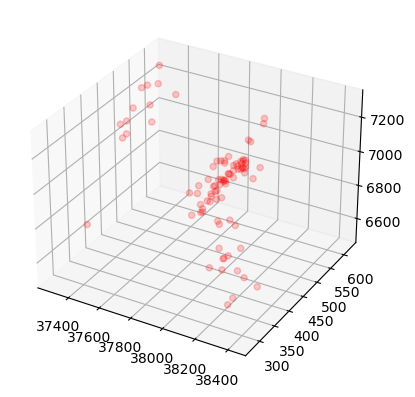

210415 SPON647_VAMP2680 8DIV_CellZone1
2
1918


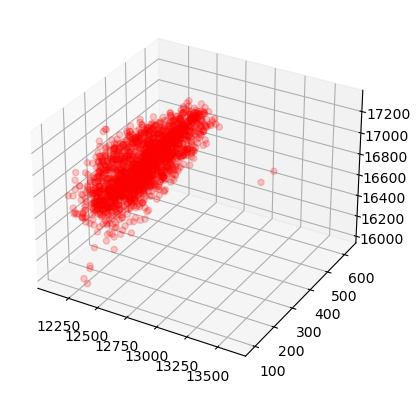

210415 SPON647_VAMP2680 8DIV_CellZone1
12
1707


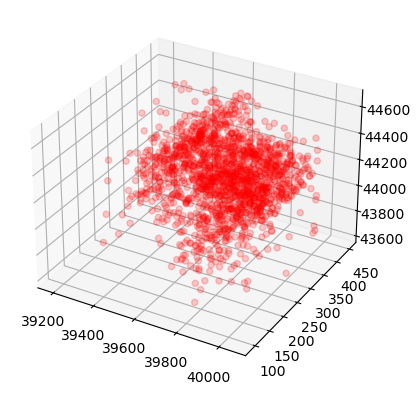

210415 SPON647_VAMP2680 8DIV_CellZone1
8
1550


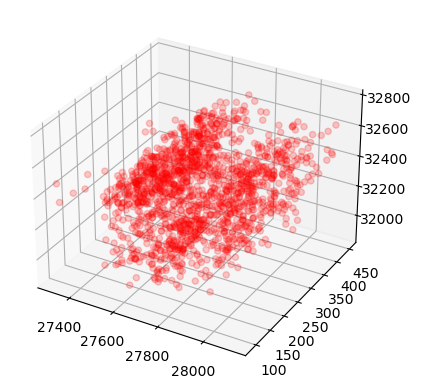

210415 SPON647_VAMP2680 8DIV_CellZone1
3
1243


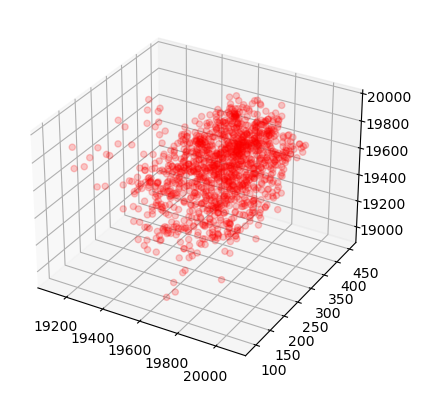

210415 SPON647_VAMP2680 8DIV_CellZone1
1
1079


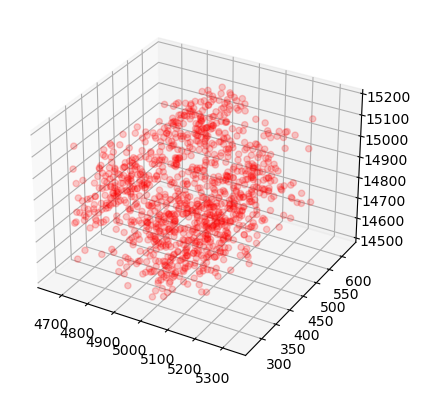

210415 SPON647_VAMP2680 8DIV_CellZone5
1
245


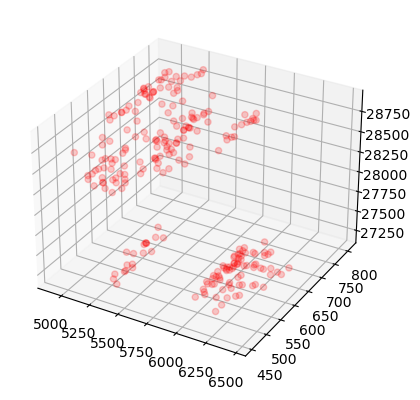

210415 SPON647_VAMP2680 8DIV_CellZone5
19
210


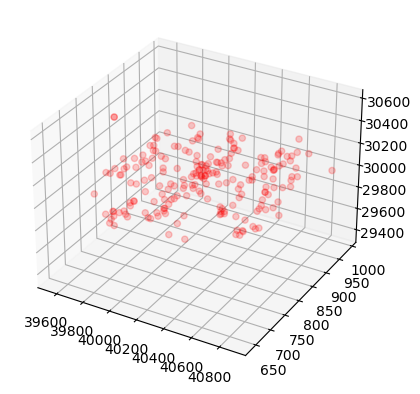

210415 SPON647_VAMP2680 8DIV_CellZone5
2
232


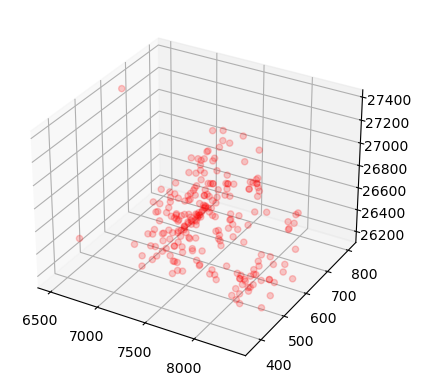

210415 SPON647_VAMP2680 8DIV_CellZone5
18
203


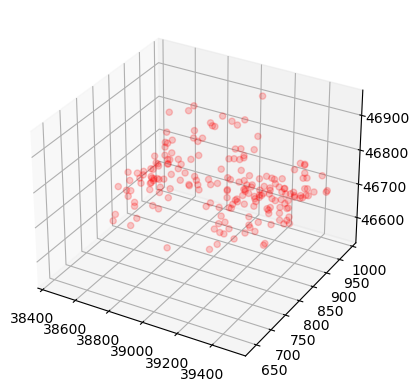

210415 SPON647_VAMP2680 8DIV_CellZone5
8
265


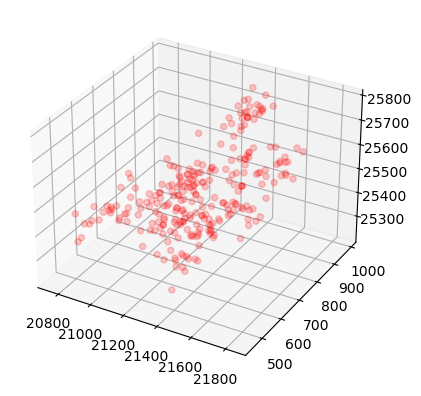

210415 SPON647_VAMP2680 8DIV_CellZone5
15
169


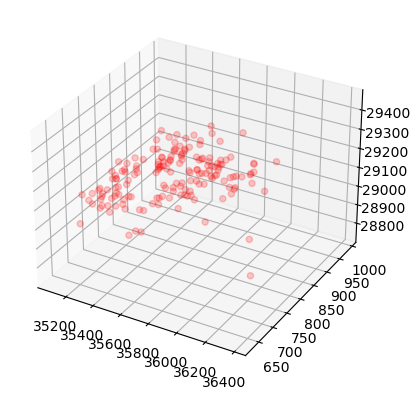

210415 SPON647_VAMP2680 8DIV_CellZone5
3
157


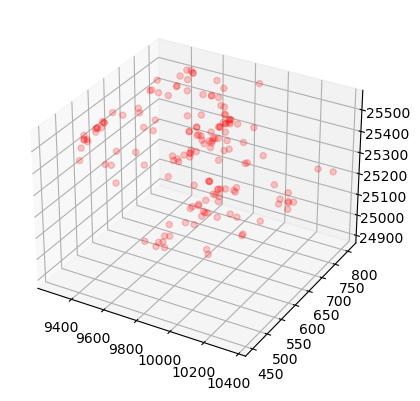

210415 SPON647_VAMP2680 8DIV_CellZone5
21
232


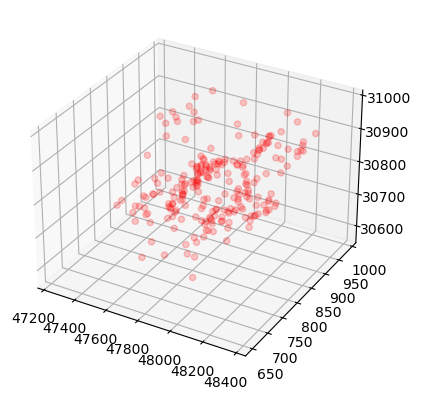

210415 SPON647_VAMP2680 8DIV_CellZone5
5
168


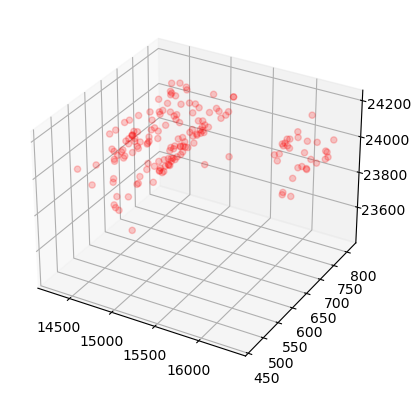

210415 SPON647_VAMP2680 8DIV_CellZone5
20
45


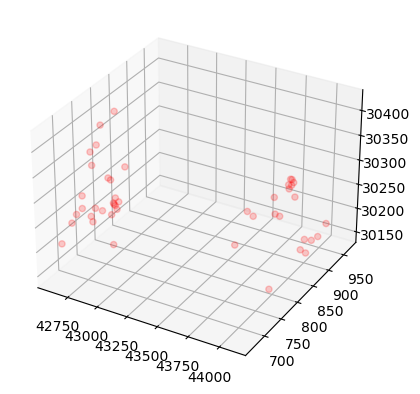

210415 SPON647_VAMP2680 8DIV_CellZone5
10
164


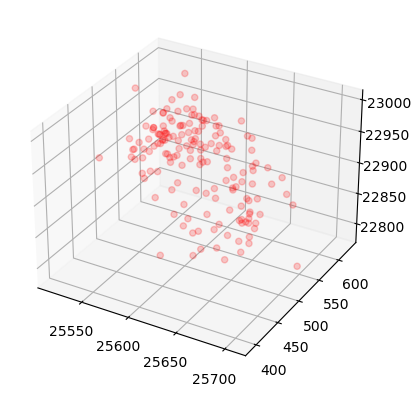

In [171]:
#VISUALISE

for i in list(vesicle_clusters.keys()):
    for j in list(vesicle_clusters[i].keys()):
        print(i)
        print(j)
        print(vesicle_clusters[i][j].shape[0])
        
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')

        ax.scatter(vesicle_clusters[i][j][:,0], vesicle_clusters[i][j][:,2], vesicle_clusters[i][j][:,1], c = 'r', marker='o', alpha=0.2)
    
        plt.show()

In [457]:
density_est = {}
mean_dens = {}
for i in keywords:
    print(i)
    for j in range(0, len(data_sorted[i])):
            data = data_sorted[i][j].T

            #determine bounding box for the density estimation of points in the synapse
            xmin = data[0].min()
            xmax = data[0].max()
            ymin = data[1].min()
            ymax = data[1].max()
            zmin = data[2].min()
            zmax = data[2].max()
            
            #get kde based on data
            kde = sc.gaussian_kde(data, 10)
            
            #define the kernel size in all dimensions
            xstep = int((xmin-xmax)/40)
            ystep = int((ymin-ymax)/40)
            zstep = int((zmin-zmax)/40)
            
            #projec the kde onto a grid of points within the bounding box given a timestep
            X, Y, Z = np.mgrid[xmin:xmax:(xstep*1j), ymin:ymax:(ystep*1j), zmin:zmax:(zstep*1j)]
            positions = np.vstack([X.ravel(), Y.ravel(), Z.ravel()])
            kde_est = np.reshape(kde(positions).T, X.shape)
            mean = np.mean(kde_est)
            var = np.std(kde_est)
            if i in density_est:
                density_est[i] = np.append(density_est[i], kde_est)
            else:
                density_est[i] = kde_est
                
            if i in mean_dens:
                mean_dens[i] = np.append(mean_dens[i], [mean, var])
            else:
                mean_dens[i] = [mean, var]


SPON
DEP


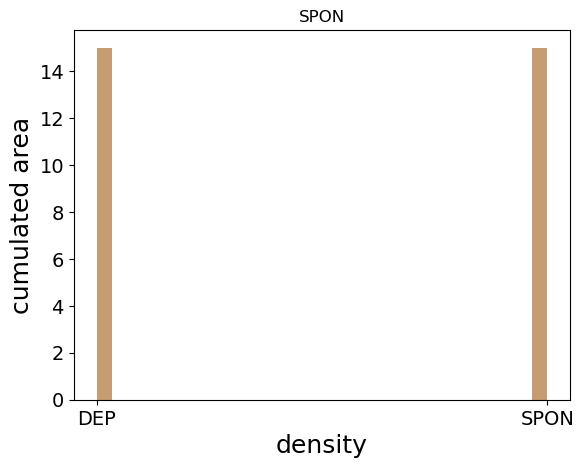

NameError: name 'mean_dens' is not defined

In [8]:
threshold=1e-10
#list_of_thresholds = list(range(0, threshold, 10))

file_dic = min_coloc_dist

for key in list(file_dic.keys()):
    #data = file_dic[key][(file_dic[key]<threshold)]
    data = file_dic
    #data = data.flatten()
    plt.title(key)
    plt.hist(data, bins = 30, label= list(file_dic.keys()), alpha=0.5, density=True)
    plt.xlabel('density', fontsize = 18)
    plt.ylabel('cumulated area', fontsize = 18)
    plt.xticks(fontsize = 14)
    plt.yticks(fontsize = 14)
plt.show()

plt.boxplot(list(mean_dens.values()), showmeans=True, labels=list(file_dic.keys()))
plt.xticks(fontsize=6)
plt.title(f'average density profile')

for i in range(0, len(list(file_dic.keys()))):
    stats = sc.describe(file_dic[list(file_dic.keys())[i]])
    print(list(file_dic.keys())[i], stats)
    

In [119]:
#compute the nearest neighbor distance and ratio

def getArea(points):
    """returns a list containing the bottom left and the top right 
    points in the sequence
    Here, we use min and max four times over the collection of points
    """
    xmin = points[:,0].min()
    xmax = points[:,0].max()
    ymin = points[:,1].min()
    ymax = points[:,1].max()
    zmin = points[:,2].min()
    zmax = points[:,2].max()

    return (xmax - xmin) * (ymax - ymin) * (zmax - zmin)

NND = {}
NNR = {}
for i in keywords:
    for array in data_sorted[i]:
        tree = KDTree(array)
        nearest_dist, nearest_ind = tree.query(array, k=2) 
        nearest_dist = nearest_dist[:,-1]
        
        mean_NND = sum(nearest_dist)/len(array)

        area = getArea(array)
        exp_mean_NND =  0.5/np.sqrt(len(array)/area)     
        NNR_t = mean_NND/exp_mean_NND
        
        if i in NND:
            NND[i] = np.concatenate((NND[i], nearest_dist))
        else:
            NND[i] = nearest_dist.flatten()
            
        if i in NNR:
            NNR[i] = np.concatenate((NNR[i], [NNR_t]))
        else:
            NNR[i] = NNR_t.flatten()


In [296]:
for i in range(0, len(list(NND.keys()))):
    plt.title(list(NND.keys())[i])
    plt.hist(NND[list(NND.keys())[i]], bins = 20)

plt.plot(list(NNR.values()), labels=list(file_dic.keys()))


NameError: name 'NND' is not defined

In [63]:
#create figures for the rotation report

file_loc = '/users/isabellegarnreiter/documents/vesicleSTORM/data/STORM_csv_files/34/'

vesicle_file = '210414 SPON647_PSD680 8DIV_CellZone2_w2'
psd_file = '210414 SPON647_PSD680 8DIV_CellZone2_w1'

ex_data_vesicles = pd.read_csv(file_loc+vesicle_file)[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
ex_data_vesicles[:,2] +=550

ex_data_PSD = pd.read_csv(file_loc+psd_file)[['x [nm]', 'y [nm]', 'z [nm]']].to_numpy(dtype=np.float64)
ex_data_PSD[:,2] +=550

params = {}
params['true_roi_size'] = (49660,49660,1100)
params['sf']  = (68, 68, 180)
params['kernel_size'] = (40,40,2)
params['sigma'] = 8
params['min_threshold_ves'] = 4
params['min_peak_dist'] = 16
params['min_cluster_area'] = 32
params['max_cluster_area'] = 32000


In [64]:
import numpy as np
from numba import njit, prange
import pandas as pd
import matplotlib.pyplot as plt
import scipy.ndimage as ndimage
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed
import math
from skimage import measure

def filter_clusters(img, min_area, max_area):
    """Filters clusters in 3D image based on their area"""
    regions = measure.regionprops(img)
    filtered_img = np.zeros_like(img)
    for region in regions:
        if region.area >= min_area and region.area<=max_area:
            for coord in region.coords:
                filtered_img[coord[0], coord[1], coord[2]] = region.label

    return filtered_img


true_roi_size = params['true_roi_size'] 
sf = params['sf']
kernel_size = params['kernel_size']
sigma = params['sigma']
min_threshold_ves = params['min_threshold_ves']

min_peak_dist = params['min_peak_dist'] 
min_cluster_area = params['min_cluster_area']
max_cluster_area = params['max_cluster_area']

image_size = (true_roi_size[0]//sf[0], true_roi_size[1]//sf[1], true_roi_size[2]//sf[2])

#plot the locations of the vesicles using the same image size as above to a single pixel size and using a large point spread function
image = fcts.map_to_im(ex_data_vesicles, true_roi_size, image_size)
indices = np.array(np.where(image>100))
image[indices.T] = 0
gaussian_fit_image = fcts.get_gaussiankde(image, kernel_size, sigma)

#calculate the intensity threshold for the large PSF images, depending on an arbitrary intensity threshold, dependent on the mean and std of each image.
threshold = gaussian_fit_image.mean() + gaussian_fit_image.std() * min_threshold_ves

#create a mask of the large PSF images where for the pixels above the threshold
mask = (gaussian_fit_image > threshold) * 1

#get the local peaks, defining the central coordinate of synapses
peak_coords = peak_local_max(gaussian_fit_image,labels = mask)

#filter the peak distances to exclude peaks which are too close to one another and replace them by the  midway point
peak_coords = np.array(fcts.filter_peaks(peak_coords, min_peak_dist))

#create labels for each peak
shell = np.zeros(image.shape, dtype=bool)
shell[tuple(peak_coords.T)] = True
markers, _ = ndi.label(shell)

#apply watershed to seperate clusters, based on the previously computed mask and the local peaks
synapse_clusters = watershed(-gaussian_fit_image, markers = markers, mask=mask, watershed_line=True)


#filtered_clusters
filtered_clusters = filter_clusters(synapse_clusters, min_cluster_area, max_cluster_area)


points= fcts.get_points(ex_data_vesicles, filtered_clusters, params)
points = np.concatenate(list(points.values()), axis=0)
points.shape

(35714, 3)

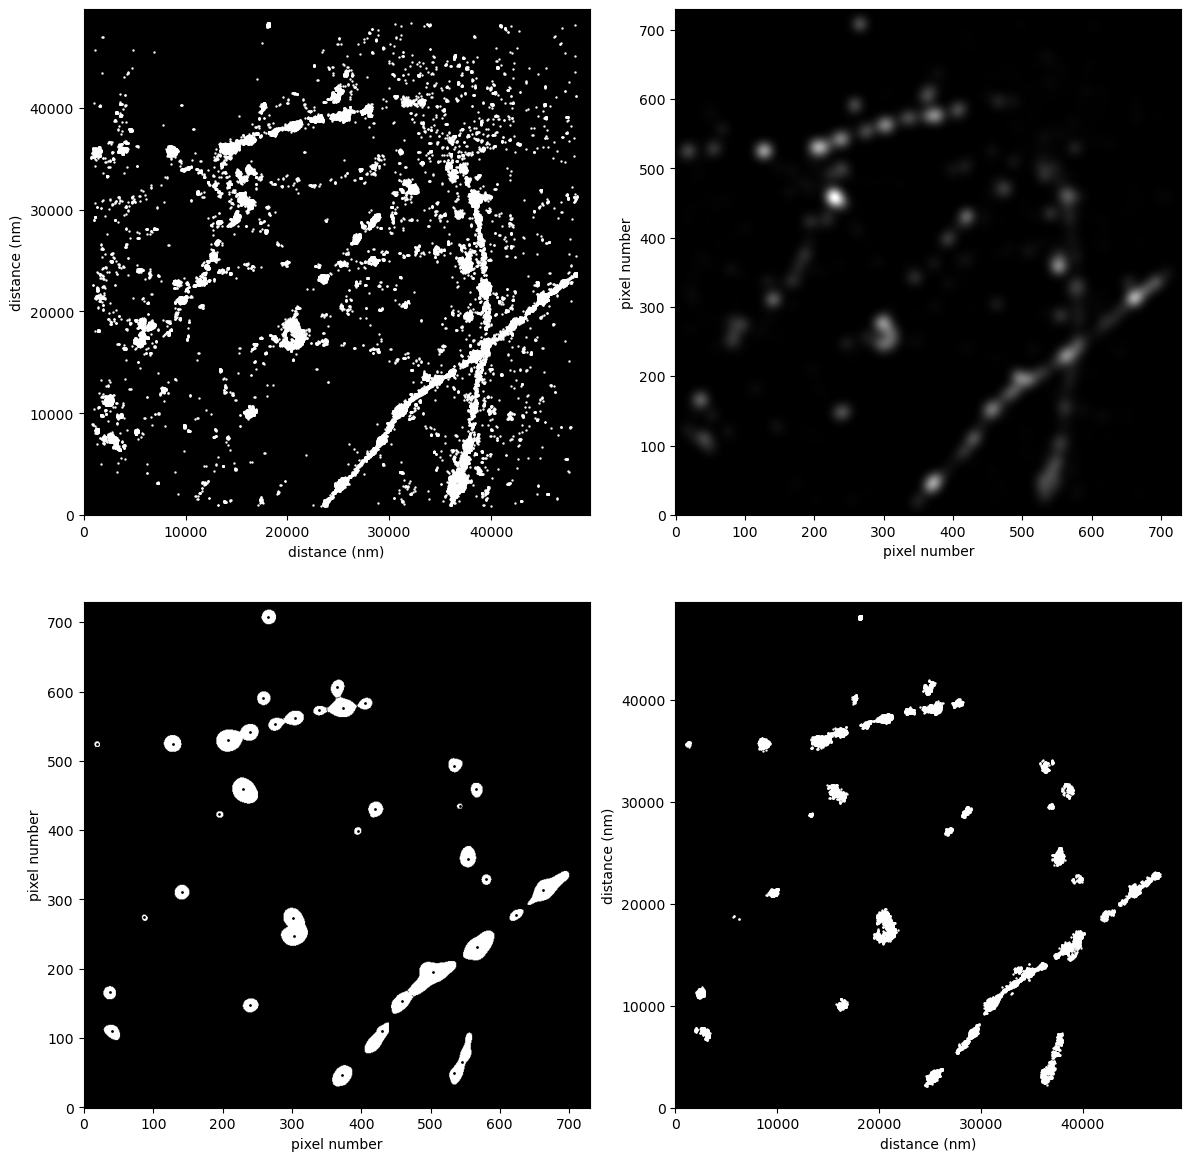

In [65]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))
axes[0,0].scatter(ex_data_vesicles[:,1], ex_data_vesicles[:,0], s=0.5, color='white')
axes[0,0].set_facecolor('black')
axes[0,0].set_aspect('equal')
axes[0,0].set_xlim(0, 49660)
axes[0,0].set_ylim(0, 49660)
axes[0,0].set_xlabel('distance (nm)')
axes[0,0].set_ylabel('distance (nm)')

gaussian_fit_image_2d = np.sum(gaussian_fit_image, axis=2)
axes[0,1].imshow(gaussian_fit_image_2d, origin = 'lower',cmap = 'gray')
axes[0,1].set_xlabel('pixel number')
axes[0,1].set_ylabel('pixel number')

filtered_clusters_2d = np.sum(filtered_clusters, axis=2)
filtered_clusters_2d = (filtered_clusters_2d > 0)*1
axes[1,0].imshow(filtered_clusters_2d, origin = 'lower', cmap = 'gray')
axes[1,0].scatter(peak_coords[:,1], peak_coords[:,0], s=1, color='black')
axes[1,0].set_xlabel('pixel number')
axes[1,0].set_ylabel('pixel number')

axes[1,1].scatter(points[:,1], points[:,0], s=0.5, color='white')
axes[1,1].set_facecolor('black')
axes[1,1].set_aspect('equal')
axes[1,1].set_xlim(0, 49660)
axes[1,1].set_ylim(0, 49660)
axes[1,1].set_xlabel('distance (nm)')
axes[1,1].set_ylabel('distance (nm)')


plt.tight_layout()